In [1]:
# set up autoreload
%reset
%load_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
!pip install tensorflow_addons
!pip install loguru
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
print(sys.path)

Mounted at /content/drive
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/Project']


In [4]:
# Testing data path
test_clip_name = 'Data_2023-10-24_10-28-15'
test_clip_path = r'/content/drive/My Drive/Project/Data_Test/' + test_clip_name + '.avi'
test_text_path = r'/content/drive/My Drive/Project/Data_Test/' + test_clip_name + '_merge.txt'
cp_path = r"/content/drive/MyDrive/Project/Checkpoints/cp.ckpt" #r"/content/drive/MyDrive/Project/Checkpoints/cp.ckpt.data-00000-of-00001"

In [5]:
# Training data path
train_clip_name = 'Data_2023-11-06_09-47-30'
train_clip_path = r'/content/drive/My Drive/Project/Data/' + train_clip_name + '.avi'
train_text_path = r'/content/drive/My Drive/Project/Data/' + train_clip_name + '_merge.txt'
cp_path = r"/content/drive/MyDrive/Project/Checkpoints/cp.ckpt" #r"/content/drive/MyDrive/Project/Checkpoints/cp.ckpt.data-00000-of-00001"

In [6]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from script.dataset import DataManager, FrameDataGenerator

# check gpu
print(tf.sysconfig.get_build_info())
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices())

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


OrderedDict([('cpu_compiler', '/usr/lib/llvm-16/bin/clang'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '11.8'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', True)])
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
import cv2
from tqdm import tqdm

def get_frames(clip_path):

  frame_input, frame_output = None, None
  frames = None

  cap = cv2.VideoCapture(clip_path)
  length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  for _ in tqdm(range(length)):

    ret, frame = cap.read()

    if ret == True:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

      if len(frame.shape)==2:
        frame = frame[:,:,np.newaxis]

      if not ret:
        return None,None

      if frames is None:
        frames = frame
      else:
        frames = np.concatenate((frames, frame),axis=2)

  frames = tf.image.convert_image_dtype(frames, dtype=tf.float32)
  frames = tf.image.resize(frames, (96, 128))

  frames = (frames-0.5)/0.1

  frame_input = frames[:,:,:]
  frame_output = (frames[:,:,-1])[:,:,tf.newaxis]

  return frame_input#, frame_output

In [8]:
# Test get_frames function
import matplotlib.pyplot as plt

frame_in_test = get_frames(test_clip_path)
print('Testing data complete\n')
frame_in_train = get_frames(train_clip_path)
print('Training data complete')

# plt.subplot(1,2,1)
# plt.imshow(frame_in[:,:,1],'gray')
# plt.subplot(1,2,2)
# plt.imshow(frame_in[:,:,0],'gray')

100%|██████████| 4488/4488 [07:22<00:00, 10.14it/s]


Testing data complete



100%|██████████| 4496/4496 [07:27<00:00, 10.05it/s]


Training data complete


In [9]:
def get_actions_file(text_path):

  action_data = None

  data = np.loadtxt(str(text_path))
  data = data/np.std(data, axis=0, keepdims=True)
  action_data = tf.convert_to_tensor(data, dtype=tf.float32)

  return action_data

# Test function
train_action_file = get_actions_file(train_text_path)
test_action_file = get_actions_file(test_text_path)



In [10]:
def get_action(action_file, start_frame_no):

  # start_frame_no = 1
  length = action_file.shape[0]
  data = action_file[start_frame_no : start_frame_no + 10, :]
  data = tf.gather(data,axis=1,indices=[0,1,5,6])
  data = tf.math.reduce_mean(data,axis=0)

  return data

data_num = train_action_file.shape[0]

for i in tqdm(range(data_num)):
  train_act_data = get_action(train_action_file, i)
  test_act_data = get_action(test_action_file, i)



100%|██████████| 4496/4496 [00:08<00:00, 537.13it/s]


In [11]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

def ssim_metric(image1, image2):
  """Computes the structural similarity index measure (SSIM) between two images.

  Args:
    image1: The first image.
    image2: The second image.

  Returns:
    The SSIM between the two images.
  """
  ssim_val = ssim(image1, image2, data_range=image1.max() - image1.min())
  return ssim_val


In [12]:
def psnr(img1, img2):
  """
  Compute the Peak Signal to Noise Ratio (PSNR) between two images.

  Args:
    img1: The first image.
    img2: The second image.

  Returns:
    The PSNR between the two images.
  """

  mse = np.mean((img1 - img2) ** 2)
  if mse == 0:
    return 100
  return 20 * np.log10(255 / np.sqrt(mse))


In [13]:
from script.model import get_interaction_module, FramePredictionModel, custom_loss

config = {}
config["fold_n_frames"] = 10

action_dim = 4 # the txt files have 7 columns,but only 4 are used
nchan_ori=1 # convert to gray scale

img_h, img_w = 96,128

img_dim = (img_h,img_w,nchan_ori*config["fold_n_frames"])
encoder_output_dim = 2048

# set up models
layer_specs = [
                {"type":"input","kwargs":{"input_shape":img_dim}}, #0
                {"type":"conv2d","kwargs":{"filters": 128,  "kernel_size": 8, "strides":2,"activation":"relu"}}, #1
                {"type":"conv2d","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu"}}, #2
                {"type":"conv2d","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu"}}, #3
                {"type":"conv2d","kwargs":{"filters": 128, "kernel_size": 4, "strides":2,"activation":"relu"}}, #4
                {"type":"flatten"}, #5
                {"type":"dense","kwargs":{"units":encoder_output_dim,"activation":"relu"}} #6
            ]
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=img_dim),
    tf.keras.layers.Conv2D(**layer_specs[1]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(**layer_specs[2]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(**layer_specs[3]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(**layer_specs[4]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(encoder_output_dim, activation='relu')
])

# define interaction module
interaction_dim, interaction_output_dim = 2048, 2048
interaction = get_interaction_module(encoder_dim=encoder_output_dim, action_dim=action_dim, intermediate_dim=interaction_dim, output_dim=interaction_output_dim)

# interaction = tf.keras.Sequential(
#     [
#         tf.keras.layers.Dense(units=2048,activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(units=2048,activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(units=interaction_output_dim,activation='relu'),
#     ]
# )

# define decoder
# get the output size of the last conv layer
conv_out_size = encoder.layers[6].output_shape[1:]
nchan = 128
fc_dim = int(np.prod(conv_out_size[:2])*nchan)
layer_specs = [
                {"type":"input_shape","kwargs":{"shape":(interaction_output_dim,)}}, #0
                {"type":"dense","kwargs":{"units":fc_dim,"activation":"relu"}}, #1
                {"type":"reshape","kwargs":{"target_shape":(conv_out_size[0],conv_out_size[1],nchan)}}, #2
                {"type":"conv2dtr","kwargs":{"filters": 128, "kernel_size": 4, "strides":2,"activation":"relu"}}, #3
                {"type":"conv2dtr","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu"}}, #4
                {"type":"conv2dtr","kwargs":{"filters": 128, "kernel_size": 6, "strides":2,"activation":"relu", "output_padding":1}}, #5
                {"type":"conv2dtr","kwargs":{"filters": nchan_ori, "kernel_size": 8, "strides":2,"activation":None}}, #6
                ]

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(interaction_output_dim,)),
    tf.keras.layers.Dense(units=fc_dim,activation='relu'),
    tf.keras.layers.Reshape(target_shape=(conv_out_size[0],conv_out_size[1],nchan)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(**layer_specs[3]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(**layer_specs[4]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(**layer_specs[5]["kwargs"]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(**layer_specs[6]["kwargs"]),
])

# print('output shape of decoder: ', decoder.output_shape)
# make sure decoder output matches the input image's size
assert(decoder.output_shape[1:3]==img_dim[:2])
assert(decoder.output_shape[-1]==nchan_ori)

# get full model
fpm = FramePredictionModel(img_dim, action_dim, encoder,interaction, decoder)
fpm.load_weights(cp_path)
fpm.build(input_shape=[(None, *img_dim),(None,action_dim)])
fpm.summary()

Model: "frame_prediction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2048)              5460480   
                                                                 
 sequential_4 (Sequential)   (None, 96, 128, 1)        5385985   
                                                                 
 model (Functional)          (None, 2048)              11362816  
                                                                 
Total params: 22209281 (84.72 MB)
Trainable params: 22200321 (84.69 MB)
Non-trainable params: 8960 (35.00 KB)
_________________________________________________________________


In [14]:
from sklearn.metrics import r2_score, mean_squared_error

def prediction(frame_in, action_file):
  pred_frames = None
  gt_frames = None

  r2_scores = []
  mse_scores = []
  PSNRs = []
  SSIMs = []

  losses = []

  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

  for i in tqdm(range(data_num-20)):

    current_frames = frame_in[:,:,i:i+10]
    frame_gt = frame_in[:, :, i+11]

    act_data = get_action(action_file, i)

    frames_expanded = tf.expand_dims(current_frames, axis=0)
    frame_gt_expanded = frame_gt[tf.newaxis,:,:,tf.newaxis]
    act_expened = tf.expand_dims(act_data, axis=0)

    # with tf.GradientTape() as tape:
      # frame_out_pred = fpm([current_frames[tf.newaxis,:], act_data[tf.newaxis,:]], training=False)
    frame_out_pred = fpm((frames_expanded, act_expened), training=False)
    #   loss_value = tf.math.reduce_mean(tf.math.square(frame_gt_expanded-frame_out_pred))#fpm.compute_loss(y=frame_gt_expanded, y_pred=frame_out_pred)
    #   losses.append(loss_value.numpy())

    # grad = tape.gradient(loss_value, fpm.trainable_variables)
    # optimizer.apply_gradients(zip(grad, fpm.trainable_variables))


    # Save ground truth and predicted frames
    if pred_frames is None:
      pred_frames, gt_frames = frame_out_pred, frame_gt[:,:,np.newaxis]
    else:
      pred_frames = np.concatenate((pred_frames, frame_out_pred),axis=0)
      gt_frames = np.concatenate((gt_frames, frame_gt[:,:,np.newaxis]), axis=2)


    # r2 = r2_score(frame_gt.numpy().flatten(), frame_out_pred[0].numpy().flatten())
    # r2_scores.append(r2)

    # mse = mean_squared_error(frame_gt.numpy().flatten(), frame_out_pred[0].numpy().flatten())
    # mse_scores.append(mse)

    # pred_255 = ((pred_frames-(-10))/20)
    # pred_255 = np.clip(pred_255, 0, 1)
    # pred_255 = (pred_255*255.0).astype(np.uint8)

    # gt_255 = ((gt_frames-(-10))/20)
    # gt_255 = np.clip(gt_255, 0, 1)
    # gt_255 = (gt_255*255.0).astype(np.uint8)

    # frames_num = pred_frames.shape[0]

    # for i in range(frames_num):
    #   psnr_score = psnr(gt_255[:,:,i].flatten(), pred_255[i].flatten())
    #   PSNRs.append(psnr_score)

    #   ssim_score = ssim_metric(gt_255[:,:,i].flatten(), pred_255[i].flatten())
    #   SSIMs.append(ssim_score)

  return pred_frames, gt_frames


In [15]:
train_pred_frames, train_gt_frames = prediction(frame_in_train, train_action_file)#,  train_r2_scores, train_mse_scores, train_PSNRs, train_SSIMs
test_pred_frames, test_gt_frames = prediction(frame_in_test, test_action_file)#,  test_r2_scores, test_mse_scores, test_PSNRs, test_SSIMs

100%|██████████| 4476/4476 [08:39<00:00,  8.62it/s]


In [16]:
def to255(pred_frames, gt_frames):
  pred_255 = ((pred_frames-(-10))/20)
  pred_255 = np.clip(pred_255, 0, 1)
  pred_255 = (pred_255*255.0).astype(np.uint8)

  gt_255 = ((gt_frames-(-10))/20)
  gt_255 = np.clip(gt_255, 0, 1)
  gt_255 = (gt_255*255.0).astype(np.uint8)

  return pred_255, gt_255

Text(0.5, 1.0, 'Testing PSNR 28.99')

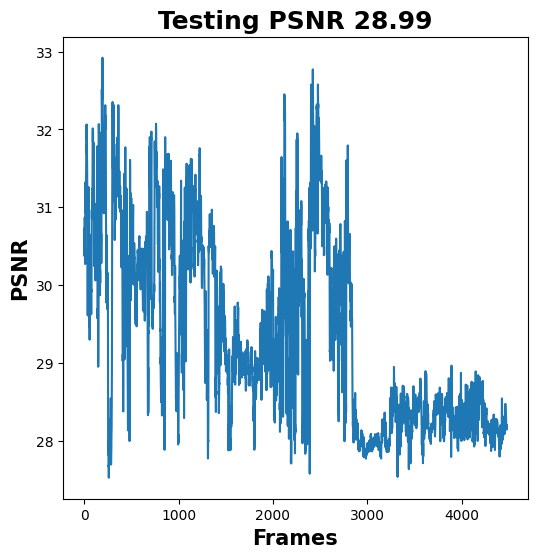

In [ ]:
PSNRs = []


pred_psnr = ((test_pred_frames-(-10))/20)
pred_psnr = np.clip(pred_psnr, 0, 1)
pred_psnr = (pred_psnr*255.0).astype(np.uint8)

gt_psnr = ((test_gt_frames-(-10))/20)
gt_psnr = np.clip(gt_psnr, 0, 1)
gt_psnr = (gt_psnr*255.0).astype(np.uint8)

frames_num = train_pred_frames.shape[0]

for i in range(frames_num):

  score = psnr(gt_psnr[:,:,i].flatten(), pred_psnr[i].flatten())
  PSNRs.append(score)

plt.figure(figsize=(6,6))

plt.plot(PSNRs)
plt.xlabel("Frames", fontsize=15, fontweight='bold')
plt.ylabel("PSNR", fontsize=15, fontweight='bold')

plt.title("Testing PSNR %.2f" %(np.median(PSNRs)), fontsize=18, fontweight='bold')



Text(0.5, 1.0, 'Testing SSIM 0.58')

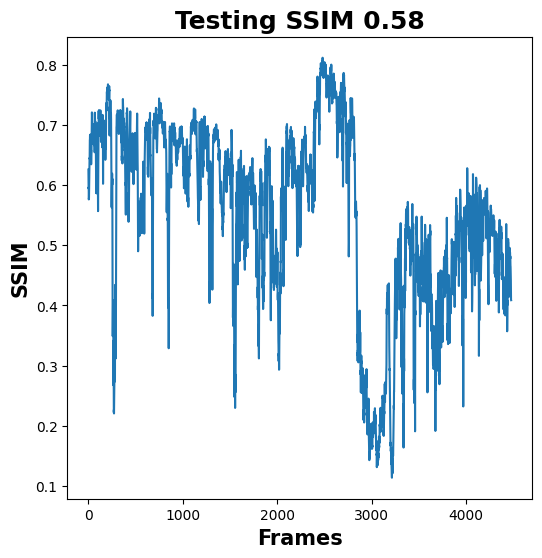

In [ ]:
SSIMs = []

pred_ssim = ((test_pred_frames-(-10))/20)
pred_ssim = np.clip(pred_ssim, 0, 1)
pred_ssim = (pred_ssim*255.0).astype(np.uint8)

gt_ssim = ((test_gt_frames-(-10))/20)
gt_ssim = np.clip(gt_ssim, 0, 1)
gt_ssim = (gt_ssim*255.0).astype(np.uint8)

for i in range(frames_num):

  score = ssim_metric(gt_psnr[:,:,i].flatten(), pred_psnr[i].flatten())
  SSIMs.append(score)

plt.figure(figsize=(6,6))

plt.plot(SSIMs)
plt.xlabel("Frames", fontsize=15, fontweight='bold')
plt.ylabel("SSIM", fontsize=15, fontweight='bold')

plt.title("Testing SSIM %.2f" %(np.median(SSIMs)), fontsize=18, fontweight='bold')

Text(0.5, 1.0, 'Testing MSE 2.30')

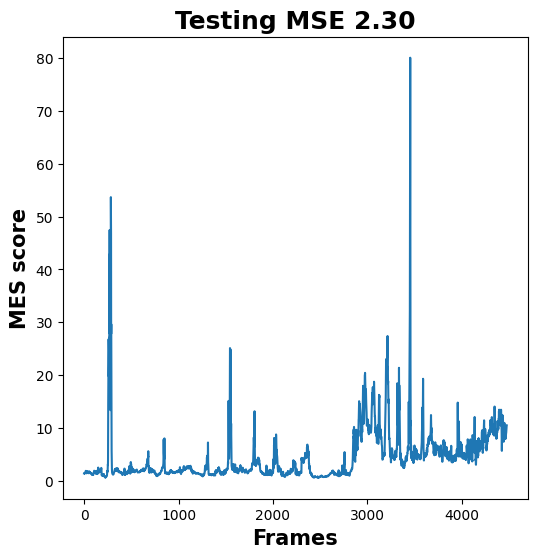

In [ ]:
mse_scores=[]

for i in range(frames_num):

  mse = mean_squared_error(test_gt_frames[:,:,i].flatten(), test_pred_frames[i].flatten())
  mse_scores.append(mse)

plt.figure(figsize=(6,6))

plt.plot(mse_scores)

plt.ylabel("MES score", fontsize=15, fontweight='bold')
plt.xlabel("Frames", fontsize=15, fontweight='bold')

plt.title("Testing MSE %.2f" %(np.median(mse_scores)), fontsize=18, fontweight='bold')

frame number:  2849
frame number:  2850
frame number:  2867
frame number:  2868
frame number:  2869
frame number:  2870
frame number:  2871
frame number:  2872
frame number:  2873
frame number:  2874
frame number:  2875
frame number:  4215
frame number:  4216


Text(0.5, 1.0, 'Testing R-Squared -1.54')

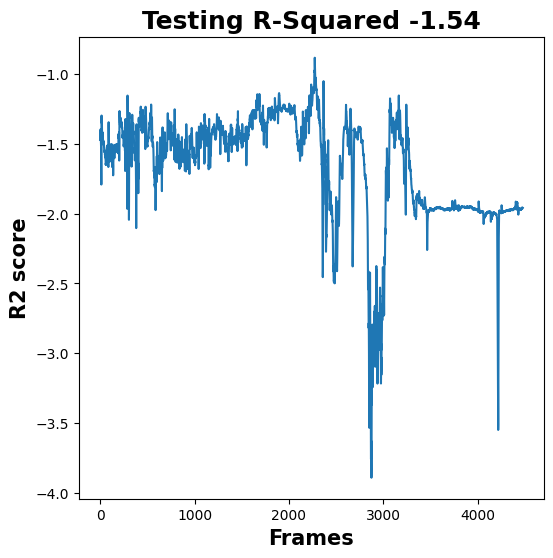

In [30]:
r2_scores=[]

for i in range(frames_num):

  r2 = r2_score(train_gt_frames[:,:,i].flatten(), train_pred_frames[0].flatten())
  if r2 < -3.5: print('frame number: ', i)
  r2_scores.append(r2)

plt.figure(figsize=(6,6))

plt.plot(r2_scores)

plt.ylabel("R2 score", fontsize=15, fontweight='bold')
plt.xlabel("Frames", fontsize=15, fontweight='bold')

plt.title("Testing R-Squared %.2f" %(np.median(r2_scores)), fontsize=18, fontweight='bold')

Text(0.5, 1.0, 'Ground truth')

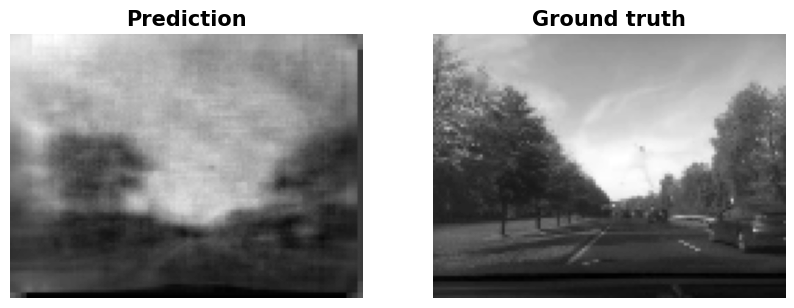

In [31]:
# print('\nMSE: %.2f' %(np.median(mse_scores)))
# print('R2 Score: %.2f' %(np.median(r2_scores)))
# print('PSNR: %.2f' %(np.median(PSNRs)))
# print('SSIM: %.2f' %(np.median(SSIMs)))
# print()

plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.imshow(train_pred_frames[2867],'gray')
plt.title("Prediction", fontsize=15, fontweight='bold')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(train_gt_frames[:, :, 2867],'gray')
plt.axis('off')
plt.title("Ground truth", fontsize=15, fontweight='bold')

(-15.0, 40.0)

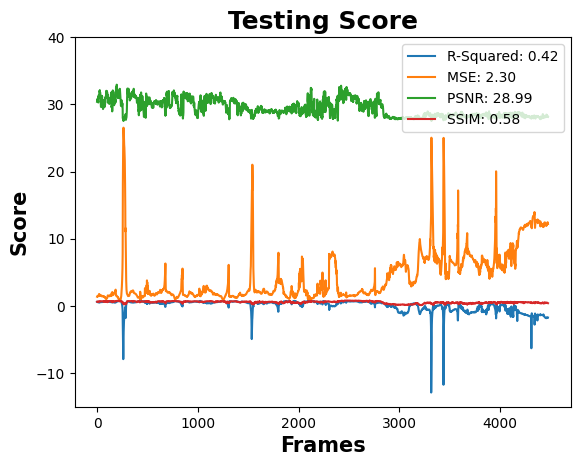

In [ ]:
plt.plot(r2_scores, label='R-Squared: %.2f' %(np.median(r2_scores)))
plt.plot(mse_scores, label='MSE: %.2f' %(np.median(mse_scores)))
plt.plot(PSNRs, label='PSNR: %.2f' %(np.median(PSNRs)))
plt.plot(SSIMs, label='SSIM: %.2f' %(np.median(SSIMs)))

plt.title("Testing Score", fontsize=18, fontweight='bold')
plt.legend(loc ="upper right", fontsize=10)

plt.xlabel("Frames", fontsize=15, fontweight='bold')
plt.ylabel("Score", fontsize=15, fontweight='bold')
plt.ylim(-15, 40)

Text(0.5, 1.0, 'Training & Testing PSNR')

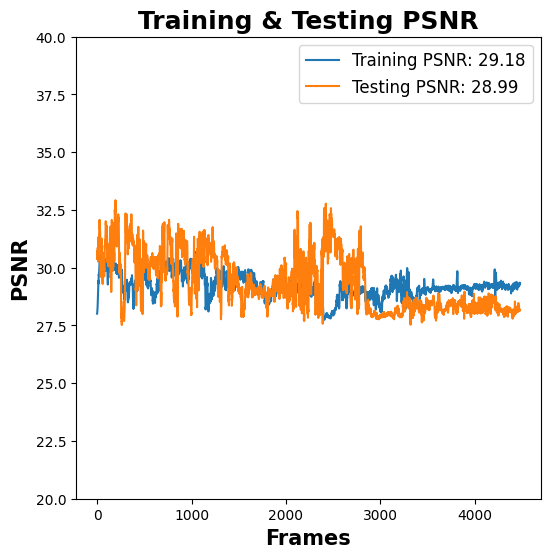

In [19]:
test_PSNRs = []
train_PSNRs = []

test_pred_psnr, test_gt_psnr = to255(test_pred_frames, test_gt_frames)
train_pred_psnr, train_gt_psnr = to255(train_pred_frames, train_gt_frames)


frames_num = train_pred_frames.shape[0]

for i in range(frames_num):

  score_test = psnr(test_gt_psnr[:,:,i].flatten(), test_pred_psnr[i].flatten())
  test_PSNRs.append(score_test)

  score_train = psnr(train_gt_psnr[:,:,i].flatten(), train_pred_psnr[i].flatten())
  train_PSNRs.append(score_train)


plt.figure(figsize=(6,6))

plt.plot(train_PSNRs, label= "Training PSNR: %.2f" %(np.median(train_PSNRs)))
plt.plot(test_PSNRs, label= "Testing PSNR: %.2f" %(np.median(test_PSNRs)))

plt.xlabel("Frames", fontsize=15, fontweight='bold')
plt.ylabel("PSNR", fontsize=15, fontweight='bold')

plt.legend(fontsize=12, loc ="upper right")

plt.ylim(20, 40)

plt.title("Training & Testing PSNR", fontsize=18, fontweight='bold')

Text(0.5, 1.0, 'Training & Testing SSIM')

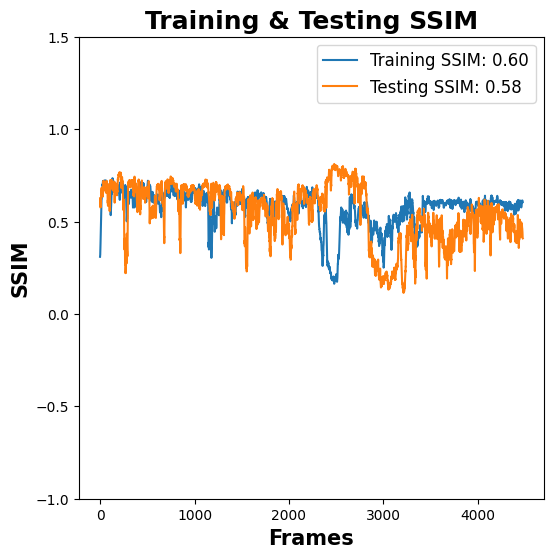

In [21]:
test_SSIMs = []
train_SSIMs = []


frames_num = train_pred_frames.shape[0]

for i in range(frames_num):

  score_test = ssim_metric(test_gt_psnr[:,:,i].flatten(), test_pred_psnr[i].flatten())
  test_SSIMs.append(score_test)

  score_train = ssim_metric(train_gt_psnr[:,:,i].flatten(), train_pred_psnr[i].flatten())
  train_SSIMs.append(score_train)


plt.figure(figsize=(6,6))

plt.plot(train_SSIMs, label= "Training SSIM: %.2f" %(np.median(train_SSIMs)))
plt.plot(test_SSIMs, label= "Testing SSIM: %.2f" %(np.median(test_SSIMs)))

plt.xlabel("Frames", fontsize=15, fontweight='bold')
plt.ylabel("SSIM", fontsize=15, fontweight='bold')

plt.legend(fontsize=12, loc ="upper right")

plt.ylim(-1, 1.5)

plt.title("Training & Testing SSIM", fontsize=18, fontweight='bold')

Text(0.5, 1.0, 'Training & Testing MSE')

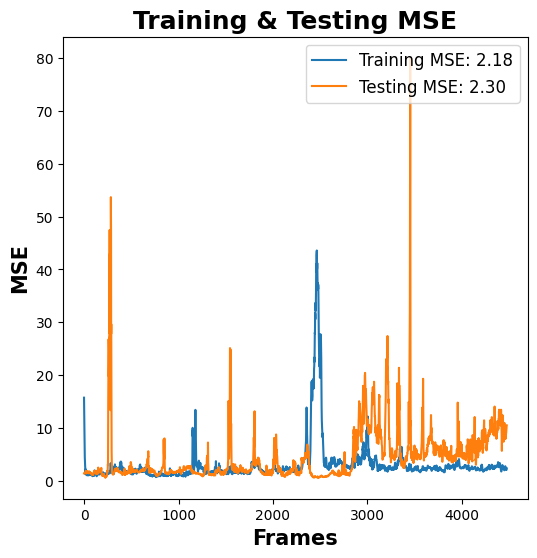

In [ ]:
test_mse_scores = []
train_mse_scores = []


frames_num = train_pred_frames.shape[0]

for i in range(frames_num):

  score_test = mean_squared_error(test_gt_frames[:,:,i].flatten(), test_pred_frames[i].flatten())
  test_mse_scores.append(score_test)

  score_train = mean_squared_error(train_gt_frames[:,:,i].flatten(), train_pred_frames[i].flatten())
  train_mse_scores.append(score_train)


plt.figure(figsize=(6,6))

plt.plot(train_mse_scores, label= "Training MSE: %.2f" %(np.median(train_mse_scores)))
plt.plot(test_mse_scores, label= "Testing MSE: %.2f" %(np.median(test_mse_scores)))

plt.xlabel("Frames", fontsize=15, fontweight='bold')
plt.ylabel("MSE", fontsize=15, fontweight='bold')

plt.legend(fontsize=12, loc ="upper right")

plt.title("Training & Testing MSE", fontsize=18, fontweight='bold')

Text(0.5, 1.0, 'Training & Testing R2')

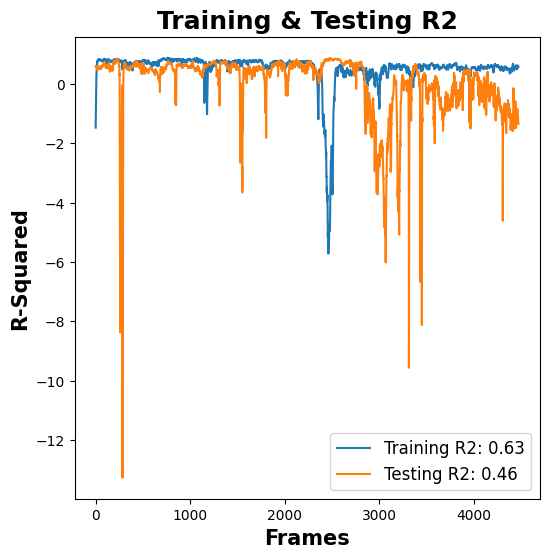

In [ ]:
test_r2_scores = []
train_r2_scores = []


frames_num = train_pred_frames.shape[0]

for i in range(frames_num):

  score_test = r2_score(test_gt_frames[:,:,i].flatten(), test_pred_frames[i].flatten())
  test_r2_scores.append(score_test)

  score_train = r2_score(train_gt_frames[:,:,i].flatten(), train_pred_frames[i].flatten())
  train_r2_scores.append(score_train)


plt.figure(figsize=(6,6))

plt.plot(train_r2_scores, label= "Training R2: %.2f" %(np.median(train_r2_scores)))
plt.plot(test_r2_scores, label= "Testing R2: %.2f" %(np.median(test_r2_scores)))

plt.xlabel("Frames", fontsize=15, fontweight='bold')
plt.ylabel("R-Squared", fontsize=15, fontweight='bold')

plt.legend(fontsize=12, loc ="lower right")

plt.title("Training & Testing R2", fontsize=18, fontweight='bold')

In [ ]:
# Save video
save_path = r'/content/drive/My Drive/Project/'

frame_size = (128*2, 96)

frames_save = ((pred_frames-(-10))/20)
frames_save = np.clip(frames_save, 0, 1)
frames_save = (frames_save*255.0).astype(np.uint8)

gt_frames_save = ((gt_frames-(-10))/20)
gt_frames_save = np.clip(gt_frames_save, 0, 1)
gt_frames_save = (gt_frames_save*255.0).astype(np.uint8)

save_clip = cv2.VideoWriter(save_path + clip_name + '_pred.avi',  cv2.VideoWriter_fourcc('M','J','P','G'), 15, frame_size)

for i in tqdm(range(frames_save.shape[0])):
  frame_combine = np.hstack((gt_frames_save[:,:,i], frames_save[i].reshape(96,128)))
  # print(frame_combine.shape)
  save_clip.write(cv2.cvtColor(frame_combine, cv2.COLOR_GRAY2BGR))

save_clip.release()

100%|██████████| 4476/4476 [00:02<00:00, 1837.36it/s]
